In [ ]:
import torch #to make the model
import torch.nn.functional as F
import pandas as pd #reading the xls file with the modern names
import matplotlib.pyplot as plt #creating the loss plot
%matplotlib inline

In [ ]:
import gdown

!gdown 1_x4_o961lfxQ46wHHN0YcBNH8ZURI_IO #modern: nombres_por_edad_media.xls

!gdown 1--wzxkim29aBgqy3WZHLnDcWdkzKXcfs #older: 0_old_names_final.txt

Downloading...
From: https://drive.google.com/uc?id=1_x4_o961lfxQ46wHHN0YcBNH8ZURI_IO
To: /content/nombres_por_edad_media.xls
100% 5.15M/5.15M [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--wzxkim29aBgqy3WZHLnDcWdkzKXcfs
To: /content/0_old_names_final.txt
100% 7.27k/7.27k [00:00<00:00, 33.1MB/s]


In [ ]:
#Function for obtaining names from excel sheet and converting to list
def get_names(sheet_name):
  df = pd.read_excel('nombres_por_edad_media.xls', sheet_name=sheet_name, skiprows=6) #Sheet name because there's a tab for each sex + skip the first 6 rows with text
  filtered_names = df[df['Edad Media (*)'] <= 60]['Nombre'].tolist() #We only want the names with an average age lower than 60ys
  filtered_names = filtered_names[:500] #We only keep the first 500 names
  return [str(name).lower() for name in filtered_names]

male_names = get_names('Hombres')
female_names = get_names('Mujeres')

#Combine into a single list
names_modern = male_names + female_names
print(len(names_modern))
print(names_modern[10]) #Confirm correct formatting

1000
carlos


In [ ]:
names_old = open('0_old_names_final.txt', 'r').read().splitlines()
names_old = [name.lower() for name in names_old]
print(len(names_old))
print(names_old[:10]) #Confirm correct formatting

808
['josefa', 'apolinar', 'maria magdalena', 'ceres', 'clotilde', 'ernesta', 'trifon', 'celso', 'saturnino de la cruz', 'lauro']


In [ ]:
#########################################
    ###### MODERN NAMES MODEL ######
#########################################

def name_generator(a_list):
  separation = "\n" + "-" * 40 + "\n" #used along the function to better visualize the output
  # build the vocabulary of characters and mappings to/from integers
  chars = sorted(list(set(''.join(a_list))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  print(f"Character Vocabulary and Mapping: {itos}")

  print(separation)

  # build the dataset
  block_size = 3 #sets context length: how many characters do we take to predict the next one?
  def build_dataset(words):
    X, Y = [], [] #The 'X' are the input to the neural net, and the 'Y' are the labels for each example inside X

    for w in words:
      #print(w)
      context = [0] * block_size #padded context of 0 tokens
      for ch in w + '.': #iterate over all characters
        ix = stoi[ch] #get the character in the sequence
        X.append(context) # build out the array 'X' which stores the current context
        Y.append(ix) #build out array 'Y' of the current character
        context = context[1:] + [ix] #crop the context and append the new character in the sequence

    X = torch.tensor(X)
    Y = torch.tensor(Y) #this is the next character in the sequence we want to predict
    print(X.shape, Y.shape)
    return X, Y

  #### split ####
  import random
  random.seed(23)
  random.shuffle(a_list)
  n1 = int(0.8*len(a_list)) #80% of words
  n2 = int(0.9*len(a_list)) #90% of words

  Xtr, Ytr = build_dataset(a_list[:n1]) #indexing up to n1 (80%) for TRAINING
  Xdev, Ydev = build_dataset(a_list[n1:n2]) #indexing between n1 and n2 (80%-90%) for VALIDATION
  Xte, Yte = build_dataset(a_list[n2:]) #indexing last 10% percent for TESTING

  #########beginning of hyperparameters#############

  g = torch.Generator().manual_seed(2147483647) #torch generator with manual seed for reproducibility

  #matrix of embeddings -> lookup table. The integers index into the lookup table. First layer of NN.
  C = torch.randn((29, 10), generator=g) #29 rows (number of chrs) in a 10-dimensional space (10 columns). Each of the 29 chrs will have a 10-dimensional embedding

  #hidden layer
  W1 = torch.randn((30, 100), generator=g) #the 30 matches the shape of the 'emb' (3 for the block size * 10 for the embedding size)
  b1 = torch.randn(100, generator=g)

  #softmax layer
  W2 = torch.randn((100, 29), generator=g)
  b2 = torch.randn(29, generator=g)

  #clustered parameters
  parameters = [C, W1, b1, W2, b2]

  ###########end of hyperparameters################


  for p in parameters: #setting the gradient requirement
    p.requires_grad = True

  #initializing lists for tracking metrics
  lossi = []
  stepi = []

  print(separation)

  for i in range(150000): #number of steps
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

  #### forward pass ####
    emb = C[Xtr[ix]]

    #hidden layer of activations
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # By using -1, we are allowing pytorch to infer the real size by seeing the other value, instead of hardcoding it
    logits = h @ W2 + b2 #defining logits: raw output of NN
    loss = F.cross_entropy(logits, Ytr[ix]) #calculating loss
    #print(loss.item())

  #### backward pass ####
    for p in parameters:
      p.grad = None #set the gradients to 0
    loss.backward() #populate the gradients

    # update
    lr = 0.7 if i < 75000 else 0.05 #step decay
    for p in parameters:
      p.data += -lr * p.grad #adjusting parameters based on gradient descent

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

  #Creating the plot
  plt.plot(stepi, lossi)
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.title('Training Loss Over Steps')
  plt.savefig('training_loss_plot.png')
  plt.show()

  print(separation)

  # training loss
  emb = C[Xtr] #Get embeddings
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Apply tanh activation to hidden layer
  logits = h @ W2 + b2 # Calculate raw output (logits) of the neural network
  loss = F.cross_entropy(logits, Ytr) # Calculate the loss using cross-entropy
  print(f"Training loss: {loss}")

  # validation loss
  emb = C[Xdev]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ydev)
  print(f"Validation loss: {loss}")

  # test loss
  emb = C[Xte]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yte)
  print(f"Test loss: {loss}")

  print(separation)

  # generation sample
  print("Model's Generation Attempt:")
  generated_names = []
  g = torch.Generator().manual_seed(2147483647)
  for _ in range(50): #number of samples
    out = []
    context = [0] * block_size #initialize with all "..."
    while True:
      emb = C[torch.tensor([context])] #embed context using embedding table "C"
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) #project into hidden space
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) #calculate probabilities. Exponentiates the logits and makes them sum to 1, which avoid overflows.
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #get next index
      context = context[1:] + [ix] #shift context window to append the index
      out.append(ix)
      if ix == 0: #until we generate the 0th character again
        break

    generated_name = ''.join(itos[i] for i in out)
    generated_names.append(generated_name)
    print(generated_name)

  return generated_names

Character Vocabulary and Mapping: {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'ñ', 0: '.'}

----------------------------------------

torch.Size([6885, 3]) torch.Size([6885])
torch.Size([863, 3]) torch.Size([863])
torch.Size([831, 3]) torch.Size([831])

----------------------------------------



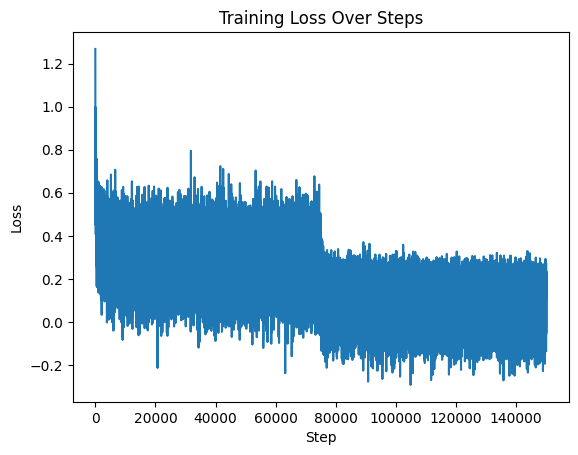


----------------------------------------

Training loss: 1.2209516763687134
Validation loss: 2.332287549972534
Test loss: 2.2736868858337402

----------------------------------------

Model's Generation Attempt:
iñoanicoluis francesa.
abdel.
rosa.
sabila.
maria.
carmo juana carmen.
abdell.
hassica.
maria.
angelenostre.
sendalle.
moham.
vicens.
pabel.
cardo.
bega.
isa isabel.
jea.
xerardo.
oria ines.
ericiac.
naiam.
sar.
blasio miguels.
ismaria.
ham.
aida.
aida.
ibai.
joaquel.
jose jose.
virgina.
sabel.
juana.
karia.
anationat.
sganil.
sar eder.
maria eurena.
jesrael.
youna.
mad.
jesusando.
abeltrancisce min.
sar.
cyntiana.
josef.
mas.
yagore.
saura.


In [ ]:
model_modern = name_generator(names_modern)

Character Vocabulary and Mapping: {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'x', 24: 'y', 25: 'z', 26: 'ñ', 0: '.'}

----------------------------------------

torch.Size([5820, 3]) torch.Size([5820])
torch.Size([711, 3]) torch.Size([711])
torch.Size([725, 3]) torch.Size([725])

----------------------------------------



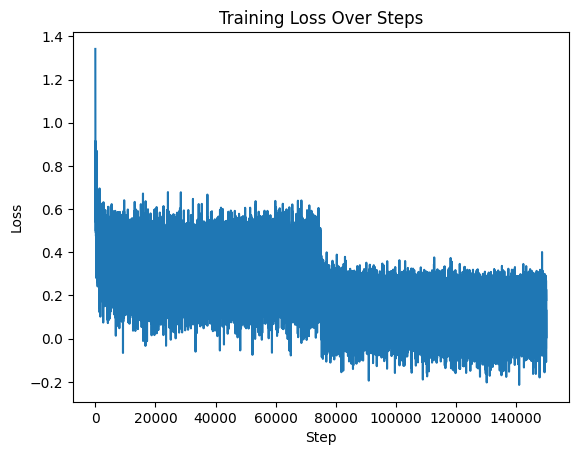


----------------------------------------

Training loss: 1.34019136428833
Validation loss: 2.7882773876190186
Test loss: 2.827613592147827

----------------------------------------

Model's Generation Attempt:
manico.
blania.
isidesio.
bara.
charonio marita.
macineto.
vinalda.
beniaco.
lrinea.
chito.
berto.
tanonriquito.
oltasiano.
toñito.
iria.
bericasro.
bernino.
cintano.
heroniel.
tobistaniel.
onfingelio.
emingora.
maripena.
tacio.
juador.
horacintanibaribeito.
pura.
patr.
maria.
paquita te de los antonio.
alfonso.
alfin.
amparro.
lucio.
luis del pepa josedalian.
nodo.
ela.
andro de la anto.
isino.
rico.
pio.
alfredorfena.
marianleda.
conso.
vina.
satuarine.
epita.
inda.
macasio.
nora.


In [ ]:
model_older = name_generator(names_old)

In [ ]:
#function to check how many of the generated names were in the original dataset
def names_in_ds(generated, dataset):
  in_ds = []
  no_period = [name.replace('.', '') for name in generated]
  for item in no_period:
    if item in dataset:
      in_ds.append(item)
    else:
      pass
  print(f"{len(in_ds)} out of {len(generated)} generated names were in the original dataset")
  print(f"Names in the original dataset: {in_ds}")
  return "Nice!"

In [ ]:
print(names_in_ds(model_modern, names_modern))

8 out of 50 generated names were in the original dataset
Names in the original dataset: ['nora', 'maria', 'francisco', 'lia', 'jose miguel', 'borja', 'maria', 'erica']
Nice!
['iñiga.', 'jose paz.', 'olga manuel.', 'ergina.', 'nora.', 'ritania.', 'maria.', 'vianandro joa.', 'mon.', 'vian.', 'jrune.']


In [ ]:
print(names_in_ds(model_older, names_old))

2 out of 50 generated names were in the original dataset
Names in the original dataset: ['pablito', 'ramon']
Nice!


In [ ]:
# References:
# [1] Karpathy, A. (2022). makemore. Retrieved from https://github.com/karpathy/makemore. Last accessed on March 1, 2024.
# [2] Instituto Nacional de Estadística. (2023). Todos los nombres con frecuencia igual o mayor a 20 personas. Last accessed on March 1, 2024. https://www.ine.es/uc/nDER2igi
# [3] José Calvo Tello (Comp.) (2017). Corpus de novelas de la Edad de Plata Würzburg: CLiGS, 2017. Last accessed on February 29, 2024. https://github.com/cligs/textbox/tree/master/spanish/novela-espanola